## Image classification with neural networks

In this problem, you will train a neural network to classify satellite images.  In the [data/EuroSAT_RGB](https://github.com/jgscott/STA380/tree/master/data/EuroSAT_RGB) directory, you will find 11 subdirectories, each corresponding to a different class of land or land use: e.g. industrial, crops, rivers, forest, etc.  Within each subdirectory, you will find examples in .jpg format of each type.  (Thus the name of the directory in which the image lives is the class label.)  

Your job is to set up a neural network that can classify the images as accurately as possible.  Use an 80/20 train test split.  Summarize your model and its accuracy in any way you see fit, but make you include _at a minimum_ the following elements:

- overall test-set accuracy, measured however you think is appropriate   
- show some of the example images from the test set, together with your model's predicted classes. 
- a confusion matrix showing the performance of the model on the set test, i.e. a table that cross-tabulates each test set example by (actual class, predicted class).  

I strongly recommend the use of PyTorch in a Jupyter notebook for this problem; look into PyTorch's `ImageFolder` data set class, which will streamline things considerably.  

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,SubsetRandomSampler
from torchvision import transforms, datasets, models
import torchvision

### Data loading and preprocessing:

In [2]:
# Step 1: Data Preprocessing
data_dir = 'data/EuroSAT_RGB'
batch_size = 32

data_transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

dataset = datasets.ImageFolder(root= data_dir,transform = data_transforms)


In [3]:
batch_size = 64
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Sample images display

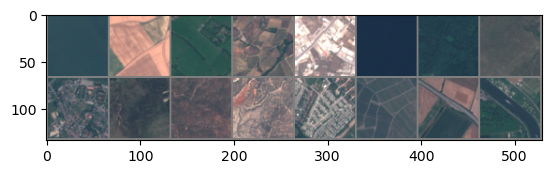

Labels: 9 0 5 6 4 9 1 2 7 2 2 2 7 6 3 8


In [4]:
import matplotlib.pyplot as plt
# Function to display a sample of images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images and display them
dataiter = iter(train_loader)
for images, labels in train_loader:
    imshow(torchvision.utils.make_grid(images[:16]))
    print('Labels:', ' '.join('%d' % labels[j] for j in range(16)))
    break  


In [5]:
class_names = dataset.classes
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
label_to_index = {k: v for k,v in class_to_idx.items()} 
idx_to_class

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

### Convolution Neural Network:

Defining the CNN architecture:

In [6]:
# Let's define a simple CNN to classify digits

import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(32, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)  # Each channel gets zeroed out independently on each forward call with probability p
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(28800, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=28800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [7]:
# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())



Training the CNN with the train set:

In [9]:
# Number of training epochs
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Clear gradients
        output = net(data)    # Forward pass
        loss = criterion(output, target)  # Calculate loss
        loss.backward()       # Backpropagation
        optimizer.step()      # Update model parameters
        running_loss += loss.item()
        
    print(f"Epoch {epoch+1}, Loss: {running_loss / (epoch+1)}")

print('Finished Training')




/Users/anveshkarangula/anaconda3/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1, Loss: 510.3981584906578
Epoch 2, Loss: 187.26011416316032
Epoch 3, Loss: 108.21257400512695
Epoch 4, Loss: 74.73791758716106
Epoch 5, Loss: 54.99923436045647
Finished Training


In [10]:
{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

Predicting the images in the train set:

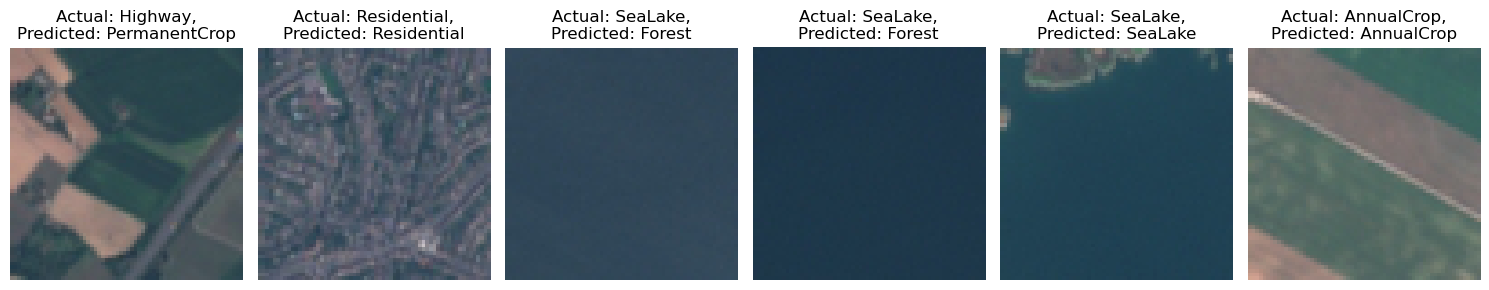

In [11]:
net.eval()

# Initialize lists to store actual and predicted labels
actual_labels = []
predicted_labels = []

count=0
fig, axes = plt.subplots(1, 6, figsize=(15, 3))  # Create a single row with 5 subplots

# Predictions on test data
with torch.no_grad():
        net.eval()  # Set the model to evaluation mode
        for val_data, val_target in test_loader:
            val_output = net(val_data)
            _, predicted = torch.max(val_output, 1)
            predicted_labels.extend(predicted.tolist())
            actual_labels.extend(val_target.tolist())
            if count != 6:
                    axes[count].imshow(((val_data[count] * 0.5) + 0.5).permute(1, 2, 0)) #Multiplied by 0.5 and added 0.5 to get original image
                    axes[count].set_title('Actual: '+idx_to_class[int(val_target[count])]
                                        +',\nPredicted: '+idx_to_class[int(predicted[count])])
                    axes[count].axis('off')
                    count += 1


plt.tight_layout()  
plt.show()





### Results and the accuracy:

The accuracy of this neural network is: 0.7853703703703704


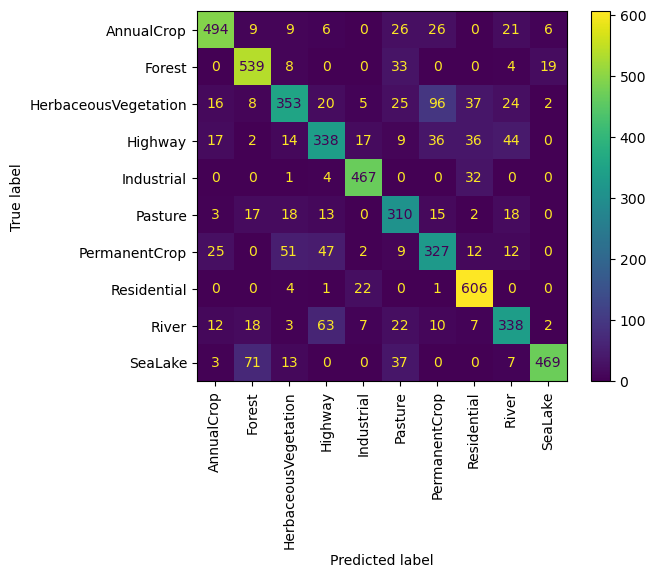

In [12]:
import sklearn.metrics as metrics
# calculate model accuracy
accuracy = metrics.accuracy_score(y_pred=(predicted_labels),y_true=actual_labels)
print('The accuracy of this neural network is: ' + str(accuracy))

# create confusion matrix
conf_matrix = metrics.confusion_matrix(y_pred=(predicted_labels),y_true=actual_labels)

# display confusion matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=label_to_index.keys())
disp.plot(xticks_rotation='vertical')
